In [1]:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

class NeuralNetwork():
  


    def __init__(self, loss='crossentropy', classifier='categorical', metric='accuracy', learning_rate=.04):
        import numpy as np
        import pandas as pd
        ALLOWED_LOSSES = ['crossentropy']
        ALLOWED_CLASSIFIERS = ['binary', 'categorical']
        ALLOWED_METRICS = ['accuracy','percision','recall','f1 score']

        self.W = [np.NaN]
        self.b = [np.NaN]
        self.Z = [np.NaN]
        self.A = [np.NaN]

        self.layer_activations = [None]
        self.layer_units = [0]
        self.layer_initializers = [None]

        self.loss_function = loss
        self.classifier = classifier
        self.metric = metric
        self.loss_history = [np.NaN]
        self.metric_history = [np.NaN]
        self.loss = 0.
        self.learning_rate = learning_rate

    def activation_func(self, z, activation=None, return_derivative=False):
        import numpy as np
        if activation == 'sigmoid':
            s = 1/(1 + np.exp(-z))
            if return_derivative:
                return s*(1 - s)

        elif activation == 'tanh':
            s = np.tanh(z)
            if return_derivative:
                return 1 - s**2

        elif activation == 'reLU':
            s = np.maximum(z, 0)
            if return_derivative:
                return (s > 0)*s

        elif activation == 'leakyrelu':
            s = np.where(z > 0, z, z * 0.01)
            if return_derivative:
              s = np.ones_like(z)
              s[z < 0] = alpha
              return s

        elif activation == 'softmax':
            max_z = np.max(z, axis=0, keepdims=True)
            s = np.exp(z - max_z)
            norm = np.sum(s, axis=0, keepdims=True)
            s = s/norm
            if return_derivative:
                return s*(1-s)

        return s

    def forward_propagate(self): 
        import numpy as np     
        num_layers = len(self.layer_units) - 1    #get the number of layers except output layer 
        for l in range(1, num_layers+1):
            self.Z[l] = np.dot(self.W[l], self.A[l-1]) + self.b[l]
            self.A[l] = self.activation_func(self.Z[l], activation=self.layer_activations[l])

    def calculate_output_dZ(self, actual):
        import numpy as np
        if self.classifier=='categorical':
            if self.loss_function=='crossentropy':
                return -actual*(1 - self.A[-1])
        elif self.classifier=='binary':
            if self.loss_function=='crossentropy':
                return -actual + self.A[-1]

    def backward_propagate(self, actual):
        import numpy as np
        m = actual.shape[-1]
        num_layers = len(self.layer_units) - 1

        # Iterate from layer L-1 to layer 1
        for l in range(num_layers, 0, -1):
            if l == num_layers:
                dZ = self.calculate_output_dZ(actual)
            else:
                g = self.activation_func(self.Z[l], activation=self.layer_activations[l], return_derivative=True)
                dZ = g*np.dot(np.transpose(self.W[l+1]), dZ) 

            dW = (1/m)*np.dot(dZ, np.transpose(self.A[l-1]))
            dB = (1/m)*np.sum(dZ, axis=1, keepdims=True)

            # Update parameters
            self.W[l] = self.W[l] - self.learning_rate*dW
            self.b[l] = self.b[l] - self.learning_rate*dB



    def calculate_loss(self, actual):
        import numpy as np
        m = actual.shape[-1]
        predicted = self.A[-1]


        if self.loss_function == 'crossentropy' and self.classifier == 'binary':
            loss_vector = -actual*np.log(predicted) - (1 - actual)*np.log(1-predicted)
        elif self.loss_function == 'crossentropy' and self.classifier == 'categorical':
            loss_vector = np.sum(-actual*np.log(predicted), axis=0, keepdims=True)

        self.loss = (1/m)*np.sum(loss_vector)
        self.loss_history.append(self.loss)


    def initialize_params(self, X_input):
        import numpy as np

        self.layer_units[0] = X_input.shape[0]
        m = X_input.shape[-1]

        num_layers = len(self.layer_units) - 1
        for l in range(1, num_layers+1):
            n_l = self.layer_units[l]
            n_prev = self.layer_units[l-1]

            if self.layer_initializers[l] == 'zeros':
                self.W.append(np.zeros(shape=(n_l, n_prev), dtype=np.float32))
                self.b.append(np.zeros(shape=(n_l, 1), dtype=np.float32))
            elif self.layer_initializers[l] == 'random':
                self.W.append(np.random.rand(n_l, n_prev).astype(np.float32))
                self.b.append(np.random.rand(n_l, 1).astype(np.float32))

            elif self.layer_initializers[l] == 'xavier':
                stddev = np.sqrt(1/n_prev)
                self.W.append(stddev*np.random.randn(n_l, n_prev).astype(np.float32))
                self.b.append(stddev*np.random.randn(n_l, 1).astype(np.float32))
            else:
                return False
            self.Z.append(np.zeros(shape=(n_l, m), dtype=np.float32))
            self.A.append(np.zeros(shape=(n_l, m), dtype=np.float32))


    def add_layer(self, units, activation='tanh', initializer='xavier'):

        self.layer_units.append(units)
        self.layer_activations.append(activation)
        self.layer_initializers.append(initializer)



    def train(self, x_train, y_train, iterations):
        import numpy as np

        if self.classifier == 'categorical':
            if y_train.ndim == 1:
                one_hot_array = np.zeros(shape=(y_train.max()+1, y_train.size))
                one_hot_array[y_train, np.arange(y_train.size)] = 1
                y_train = one_hot_array
        if self.classifier == 'binary':
            if y_train.ndim == 1:
                y_train = np.expand_dims(y_train, axis=0)


        self.A[0] = x_train
        self.initialize_params(x_train)

        print('Training neural network.')
        for i in range(iterations):

            self.forward_propagate()
            self.calculate_loss(y_train)
            self.backward_propagate(y_train)

            print_step_size = int(iterations/100) if iterations > 100 else 1
            if i % print_step_size == 0:
                print('At iteration {}, J = {}'.format(i, self.loss))

    def test(self, x_test, y_test):
        import numpy as np
        if y_test.ndim == 1:
            y_test = np.expand_dims(y_test, axis=0)

        if self.classifier == 'categorical':
            if y_test.ndim == 1:
                one_hot_array = np.zeros(shape=(y_test.max()+1, y_test.size))
                one_hot_array[y_test, np.arange(y_test.size)] = 1
                y_test = one_hot_array
        if self.classifier == 'binary':
            if y_test.ndim == 1:
                y_test = np.expand_dims(y_test, axis=0)

        self.A[0] = x_test
        self.forward_propagate()
        return self.A[-1]


    def evaluation_metric(self, prediction, actual): #calculate accuracy,precision,recall,f1_score

        import numpy as np
        import pandas as pd

        prediction_onehot = np.zeros_like(prediction) #array of zeros with same shape of prediction 
        prediction_onehot[prediction.argmax(0), np.arange(prediction.shape[1])] = 1 #all equal zero except maximum =1 [0 0 0 1 0 0 0]


        predictedClass= prediction_onehot.T #transpose one hot code
        one_dim_predicted_class=[]
        for i in range(len(predictedClass)):
            one_dim_predicted_class.append(np.argmax(predictedClass[i])) #convert one hot code to 1D array (returns the index of the max value)
        
        actual_list=actual.tolist() #convert the array to list
        sum=0
        for i in range(len(actual_list)):
          if actual_list[i]==one_dim_predicted_class[i]:
              sum+=1 #for every true prediction
        print("accuracy = ", (sum/ len(actual_list))*100) #calculate the accuracy (true predictions/total no. of examples)
        currentDataClass=actual_list
        classes = set(currentDataClass) #get the available labels without repetition 

        y_actu = pd.Series(currentDataClass) #construct a series of true labels
        y_pred = pd.Series(one_dim_predicted_class) #construct a series of predictions
        conf_matrix = pd.crosstab(y_actu, y_pred) #construct confusion matrix
        cm = conf_matrix.values

        true_pos = np.diag(cm) #get true positives
        false_pos = np.sum(cm, axis=0) - true_pos #get false positives
        false_neg = np.sum(cm, axis=1) - true_pos #get false negatives

        precision = true_pos.sum()/ (true_pos.sum() + false_pos.sum()+0.00001) #P=TP/TP+FP
        recall = true_pos.sum() / (true_pos.sum() + false_neg.sum()) #R=TP/TP+FN
        f1_score= 2*( (precision*recall) / (precision+recall) )  #F1Score=P*R/P+R
        print("precision = ",precision*100)
        print("f1_score = ",f1_score*100)
        print("recall = ",recall*100)


    def visualize(self):
      import matplotlib.pyplot as plt
      plt.plot(self.loss_history)
      plt.title('Loss Vs iterations')
      plt.xlabel('iterations')
      plt.ylabel('L')
      plt.show()



In [3]:
class Data():
      def shuffle_split_data(self,X,y,train_size=0.7): #X: input data, y:labels, 70% of data for training 
        import numpy as np
        arr_rand = np.random.rand(X.shape[0]) #shuffles data
        split = arr_rand < np.percentile(arr_rand, train_size*100) #takes 70% of data
        X_train =  np.array(X[split]).T #to reshape the data as required for model
        y_train = np.array(y[split]).ravel() #( m , ) instead of ( m, 1 )
        X_test = np.array( X[~split]).T #takes the remaining 30% for testing
        y_test = np.array(y[~split]).ravel() 
        return X_train, y_train, X_test, y_test

      def load_data(self,path,label): 
        import pandas as pd
        data=pd.read_csv(path) #read the csv data file
        Y = data[[label]] #getting data labels
        data.drop([label], inplace=True, axis=1) #dropping the label column
        X=data
        return self.shuffle_split_data(X,Y)

In [4]:
class utils(): #for saving and loading model
  def load_model(self,filename):
    import pickle 
    loaded_model = pickle.load(open(filename, 'rb')) #load the model with the last accuracy achieved
    return loaded_model

  def save_model(self,nn,filename):
    import pickle 
    pickle.dump(nn, open(filename, 'wb')) #save the last accuracy achieved model 


Training neural network.
At iteration 0, J = 2.494353681908836
At iteration 1, J = 2.4297375053404866
At iteration 2, J = 2.3974168928254023
At iteration 3, J = 2.3665485701449103
At iteration 4, J = 2.3489138864690786


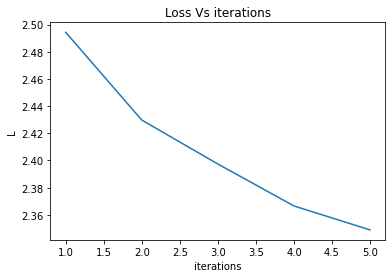

accuracy =  12.214285714285714
precision =  12.214285704591838
f1_score =  12.214285709438775
recall =  12.214285714285714


In [5]:
if __name__ == '__main__':
    # import numpy as np
    # import pandas as pd
    # Initialize the NN and build the layers
    nn = NeuralNetwork(loss='crossentropy', classifier='categorical', learning_rate=.02, metric='accuracy') #instance of class
    nn.add_layer(units=20, activation='tanh', initializer='xavier') #add layer with desired activation function
    nn.add_layer(units=40, activation='tanh', initializer='xavier')
    nn.add_layer(units=10, activation='softmax', initializer='xavier')
    data_loader=Data() #instance of data class
    path='/content/drive/MyDrive/datasets/train.csv'
    label='label'
    x_train, y_train, x_test, y_test=data_loader.load_data(path,label) #load data
    nn.train(x_train=x_train, y_train=y_train, iterations=150)
    nn.visualize()
    # Test NN on our test set
    prediction = nn.test(x_test=x_test, y_test=y_test)
    nn.evaluation_metric(prediction , y_test)
    util=utils() #instance of utils class
    filename = 'final_model2.sav' 
    util.save_model(nn,filename) #save model

In [7]:
x=util.load_model(filename)
pred=x.test(x_test,y_test)
x.evaluation_metric(pred,y_test)

accuracy =  12.214285714285714
precision =  12.214285704591838
f1_score =  12.214285709438775
recall =  12.214285714285714
